In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimBoostClassifier

## Regression

```python
from pysim import SimBoostRegressor
clf = SimBoostRegressor(n_estimators, val_ratio=0.2, degree=2, knot_num=20, knot_dist="uniform", learning_rate=0.1, ortho_shrink=1,
                 loss_threshold=0.01, reg_lambda=0.1, reg_gamma=10, stein_method="first_order", random_state=0)
```

In [2]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])

beta = np.vstack([beta1, beta2, beta3])
model_list = [lambda x: 0.2 * np.exp(-4 * x), lambda x: 3 * x ** 2, lambda x: 2.5 * np.sin(1.5 * np.pi * x)]

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(20000, 10), random_state=random_state)
noise = np.random.randn(20000).reshape(-1, 1)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [7]:
%%time 

clf = SimBoostRegressor(n_estimators=10, knot_num=20, knot_dist="quantile", learning_rate=0.1,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                        reg_gamma=[0.2, 0.4, 0.6, 0.8, 1.0])
clf.fit(train_x, train_y, inner_update=False)

CPU times: user 7min 38s, sys: 17min 58s, total: 25min 37s
Wall time: 25.1 s


In [8]:
clf.visualize()

IndexError: tuple index out of range

<Figure size 1728x0 with 0 Axes>

In [18]:
est = clf.estimators_[0]

dict_keys(['select', 'sim'])

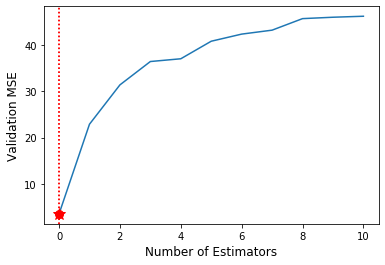

In [9]:
clf.validation_performance()

In [10]:
mean_squared_error(test_y, clf.predict(test_x))

3.553564754467745

## LogitBoost

```python
from pysim import SimBoostClassifier
clf = SimBoostClassifier(n_estimators, val_ratio=0.2, degree=2, knot_num=20, knot_dist="uniform", learning_rate=0.1, ortho_shrink=1,
                 loss_threshold=0.01, reg_lambda=0.1, reg_gamma=10, stein_method="first_order", random_state=0)
```

In [ ]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
beta = np.vstack([beta1, beta2, beta3])

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(10000, 10), random_state=random_state)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + \
    np.random.randn(10000).reshape(-1, 1)
y[y <= 0] = 0
y[y > 0] = 1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [ ]:
%%time 

clf = SimBoostClassifier(n_estimators=10, knot_num=20, knot_dist="quantile",
                         reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                         reg_gamma=[0.2, 0.4, 0.6, 0.8, 1.0])
clf.fit(train_x, train_y)

In [ ]:
clf.visualize()

In [ ]:
clf.validation_performance()

In [ ]:
roc_auc_score(test_y, clf.predict_proba(test_x))